In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

**Prediction evaluation (VCMPR@k and centralities)**

In [21]:
from utils.evaluation import read_prediction_files
seal = read_prediction_files("seal", "citeseer")

In [14]:
seal[0]["train_graph"].num_nodes()

AttributeError: 'Graph' object has no attribute 'num_nodes'

In [16]:
from utils.evaluation import read_prediction_files
gcn = read_prediction_files("gcn", "cora")

In [23]:
import networkx as nx

# Assuming gcn[0]["train_graph"] is your graph
train_graph = gcn[0]["train_graph"]

# Basic properties
num_nodes = train_graph.number_of_nodes()
num_edges = train_graph.number_of_edges()
is_directed = nx.is_directed(train_graph)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Is the graph directed? {is_directed}")

Number of nodes: 2708
Number of edges: 4488
Is the graph directed? False


In [1]:
from utils.evaluation import evaluate_all
import networkx as nx
from functools import partial
from diffusion.jackson_metrics import diffusion_centrality
eigen = partial(nx.eigenvector_centrality_numpy)
degree = partial(nx.degree_centrality)
diffusion = partial(diffusion_centrality, T=5)
names = ["eigenvector_centrality"]

data_names = ["citeseer"]
result, k_dict, metrics_dict = evaluate_all(model_name="seal", list_of_data=data_names, 
                      method_list=[eigen], 
                      method_names=names)

citeseer: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.51s/it]


In [2]:
k_dict

{'citeseer': 1}

In [3]:
metrics_dict

{'citeseer': {'AVG VCMPR@1': 0.5291828513145447}}

In [4]:
result[0]

,node_index,vcmpr_IB_min1,eigenvector_centrality_train,eigenvector_centrality_true,eigenvector_centrality_pred,dataset
0,1,1.0,-3.085017e-17,-3.672809e-17,-1.030125e-16,citeseer
1,7,0.0,-1.392167e-16,5.263036e-17,-1.791586e-16,citeseer
2,8,0.0,-9.186025e-17,2.085837e-17,-3.105803e-17,citeseer
3,10,1.0,-1.297199e-16,-1.545733e-16,-2.457552e-16,citeseer
4,12,1.0,1.575941e-16,-1.871942e-16,6.168406e-17,citeseer
...,...,...,...,...,...,...
1280,3314,1.0,1.771561e-16,-7.929389e-17,-2.440060e-16,citeseer
1281,3318,1.0,1.779273e-16,-3.540052e-17,-5.358334e-17,citeseer
1282,3322,1.0,-4.641120e-18,-2.992411e-16,-2.638576e-18,citeseer
1283,3323,1.0,-2.872388e-17,-2.915337e-16,-2.552884e-17,citeseer


**Evaluate diffusion**

In [5]:
from utils.difffusion_evaluation import evaluate_all

data_names = ["citeseer"]
result = evaluate_all(model_name="seal",
                      list_of_data=data_names,
                      eval_type='s')


Running evaluations: 100%|████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.28it/s]


In [6]:
result[0].keys()

dict_keys(['true_si', 'pred_si', 'info_vulnerability', 'metrics'])

In [7]:
import pandas as pd

# Stack all DataFrames along a new axis, then calculate the mean across all files for each node
stacked_df = pd.concat(result[0]["info_vulnerability"], axis=0).groupby(level=0).mean()

# Calculate the mean error columns
stacked_df['vulnerability_error'] = stacked_df["true_vulnerability"] - stacked_df["pred_vulnerability"]
stacked_df['recency_error'] = stacked_df['true_recency'] - stacked_df['pred_recency']

# Display the resulting DataFrame
stacked_df

,true_vulnerability,true_recency,pred_vulnerability,pred_recency,degree,file,vulnerability_error,recency_error
0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,4.5,0.0,0.0
2,0.0,0.0,0.0,0.0,3.0,4.5,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,4.5,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,4.5,0.0,0.0
...,...,...,...,...,...,...,...,...
43407,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0
43408,0.0,0.0,0.0,0.0,1.0,4.5,0.0,0.0
43409,0.0,0.0,0.0,0.0,1.0,4.5,0.0,0.0
43410,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0


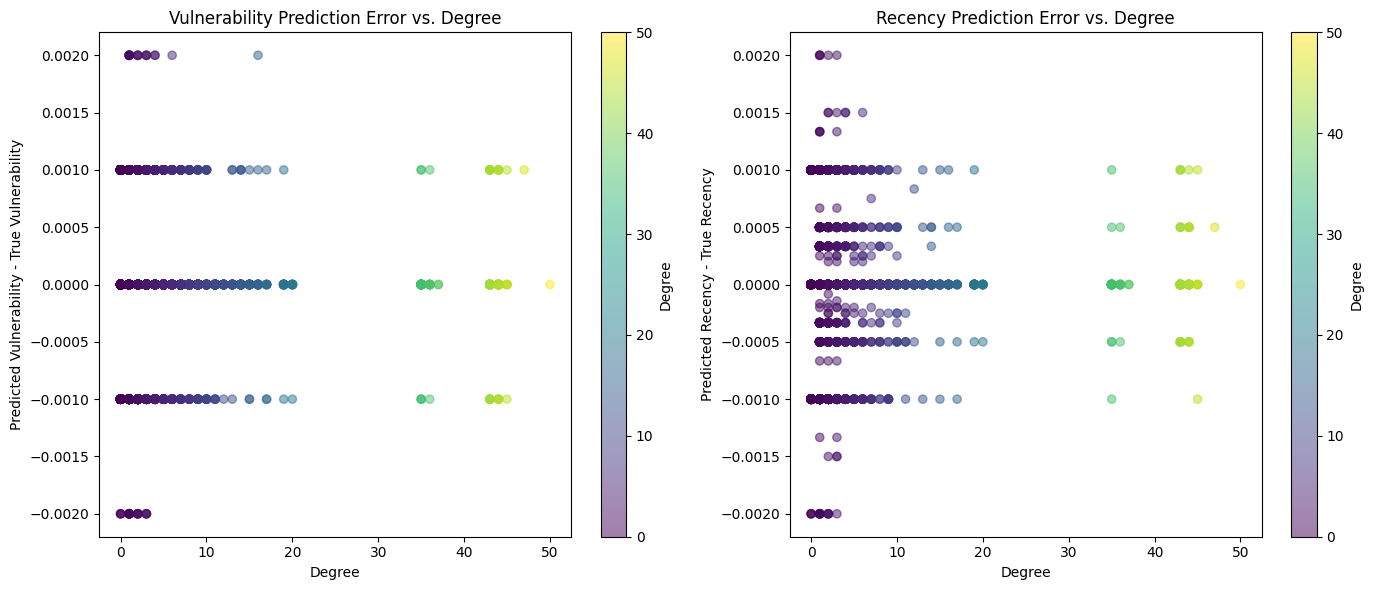

In [8]:
import matplotlib.pyplot as plt 

# Plotting prediction error for vulnerability vs degree
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(stacked_df['degree'], stacked_df['vulnerability_error'], alpha=0.5, c=stacked_df['degree'], cmap='viridis')
plt.colorbar(label='Degree')
plt.xlabel('Degree')
plt.ylabel('Predicted Vulnerability - True Vulnerability')
plt.title('Vulnerability Prediction Error vs. Degree')

# Plotting prediction error for recency vs degree
plt.subplot(1, 2, 2)
plt.scatter(stacked_df['degree'], stacked_df['recency_error'], alpha=0.5, c=stacked_df['degree'], cmap='viridis')
plt.colorbar(label='Degree')
plt.xlabel('Degree')
plt.ylabel('Predicted Recency - True Recency')
plt.title('Recency Prediction Error vs. Degree')

plt.tight_layout()
plt.show()